## Library Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklift.models import SoloModel, TwoModels, ClassTransformation
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

## Helper Functions

In [2]:
# Random Undersampling (finding the majority class and undersampling it)
def random_under(df:pd.DataFrame, feature):
    
    target = df[feature].value_counts()
    
    if target.values[0]<target.values[1]:
        under = target.index.values[1]
    
    else: 
        under = target.index.values[0]
        
    df_0 = df[df[feature] != under]
    df_1 = df[df[feature] == under]
    
    df_treatment_under = df_1.sample(len(df_0))
    df_1 = pd.concat([df_treatment_under, df_0], axis=0)
    
    return df_1

# Function to declare Target Class
def target_class(df, treatment, target):
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df[treatment] == 0) & (df[target] != 0),'target_class'] = 1 
    #TN:
    df.loc[(df[treatment] != 0) & (df[target] == 0),'target_class'] = 2 
    #TR:
    df.loc[(df[treatment] != 0) & (df[target] != 0),'target_class'] = 3 
    return df

def get_tc(treatment,target):
    """
    Function that returns helps to select the users that were in the control group and have a positive response
    
    Parameters:
    ------------
    treatment = treatment
    target = the response 
    """    
    if not target:
        return 0
    elif not treatment:
        return 1
    else:
        return 0
    
def compute_gain(df_x, uplift, treatment, y, rnd = False):
    """
    Function that computes the cumulative gains in a dataframe
    
    Parameters:
    ------------
    uplift = arr with the predicted uplifts by the models
    trtment = arr with the treatment indicator (test)
    y = arr target variable (test)
    rnd = bool indicating if random selection
    """
    e = 0.0000000000001 # to avoid divisions by zero
    base = pd.DataFrame({'uplift':uplift, 'treatment_1':treatment.values, 'target': y.values})

    df = pd.concat([df_x,base], axis = 1)
    
    #sort based on the flag
    if rnd:
        df = df.sample(frac=1).reset_index().drop('index', axis =1)
    else:
        df = df.sort_values(by='uplift', ascending = False).reset_index().drop('index', axis =1)
    
    #Compute the cumulative treatment size
    df['cum_trs'] = df['treatment_1'].cumsum(axis=0)

    #Compute the cumulative control size
    df['cum_crs'] = (df.index+1) - df['treatment_1'].cumsum(axis=0)
    
    #Compute target given treatment
    df['ttr'] = df['treatment_1'] * df['target']
    
    #Compute target given control
    df['tcr'] = df.apply(lambda x: get_tc(x.treatment_1, x.target), axis=1)
    
    #Compute cumulative target given treatment
    df['cum_ttr'] = df['ttr'].cumsum(axis=0)
    
    #Compute cumulative target given control
    df['cum_tcr'] = df['tcr'].cumsum(axis=0)
    
    #Compute cumulative gain from one to uplift [descent]
    df['cum_gain'] = (df['cum_ttr']/(df['cum_trs']+e)) - (df['cum_tcr']/(df['cum_crs']+e))
    
    #Compute cumulative gain from zero to uplift [ascending]
    df['cum_gain2'] = df['cum_gain']*(df['cum_trs']+df['cum_crs']+e)/ len(df)
    
    return df   

### Reading the file and assiging parameters

In [3]:
df = pd.read_csv("C:/Users/adity/OneDrive/Documents/Untitled Folder/criteo-uplift-v2.1.csv")

In [4]:
treatment_col = 'exposure'
target_col = 'visit'
drop_lst = ['conversion','exposure','treatment','visit']
drop_lst.remove(treatment_col)
drop_lst.remove(target_col)

## Exploratory Data Analysis (EDA) 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [6]:
df.isnull().sum()

f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

In [7]:
print('Total number of samples: {}'.format(len(df)))

Total number of samples: 13979592


### Dataset summary:
- There are 12 features and 2 variables for treatment (treatment and exposure) and 2 variables for target (conversion and visit)
- There are no null values in the 13M users

<Axes: title={'center': 'Pearson Correlation Matrix'}>

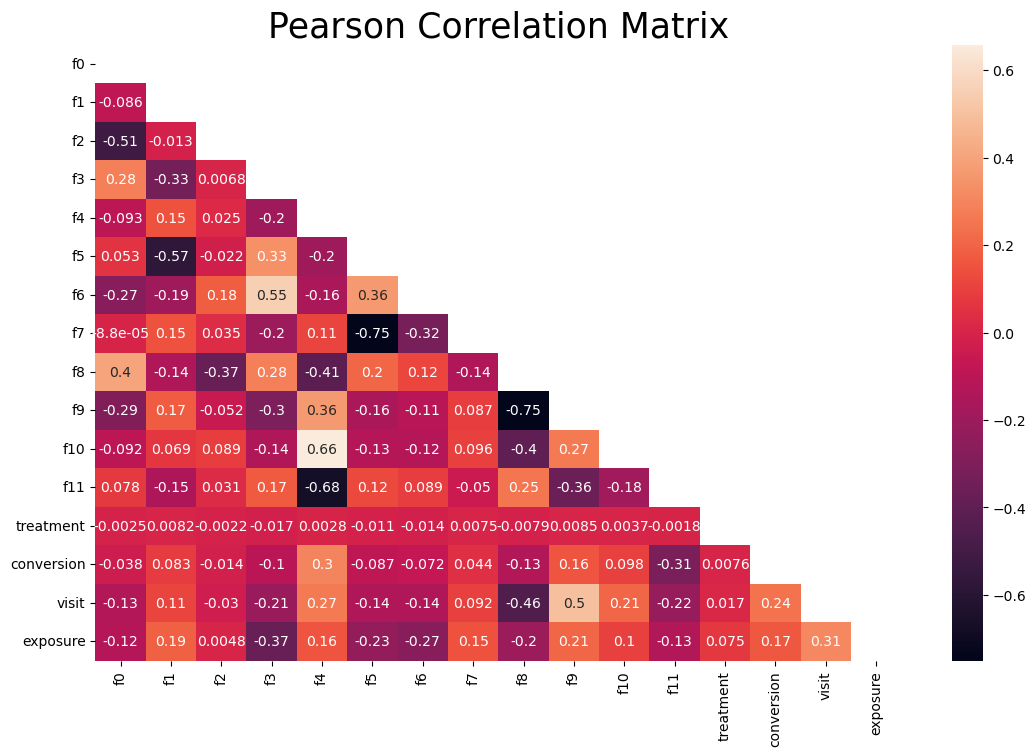

In [8]:
#Correlation Matrix
f, ax = plt.subplots(figsize=(13, 8))
plt.title('Pearson Correlation Matrix',fontsize=25)

corr = df.corr()

mask = np.zeros_like(corr, dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

sns.heatmap(corr, annot=True, mask = mask)

In [9]:
print('Percentage of users that visit: {}%'.format(100*round(df['visit'].mean(),4)))
print('Percentage of users that convert: {}%'.format(100*round(df['conversion'].mean(),4)))
print('Percentage of visitors that convert: {}%'.format(100*round(df[df["visit"]==1]["conversion"].mean(),4)))

Percentage of users that visit: 4.7%
Percentage of users that convert: 0.29%
Percentage of visitors that convert: 6.21%


Once again, both binary labels (visits and conversions) exhibit significant imbalances. How do these metrics differ between the control and treatment groups?

In [10]:
vis_results_df = df.groupby('treatment').agg({'visit':['mean', 'sum', 'count']})
vis_results_df

visit                  
               mean     sum     count
treatment                            
0          0.038201   80105   2096937
1          0.048543  576824  11882655

In [11]:
con_results_df = df.groupby('treatment').agg({'conversion':['mean', 'sum', 'count']})
con_results_df

conversion                 
                mean    sum     count
treatment                            
0           0.001938   4063   2096937
1           0.003089  36711  11882655

In [12]:
print(f'Difference in clickthrough rate between treatment and control: {np.round(df.groupby("treatment")["visit"].mean()[1] - df.groupby("treatment")["visit"].mean()[0], 4)}')
print(f'Difference in conversion between treatment and control: {np.round(df.groupby("treatment")["conversion"].mean()[1] - df.groupby("treatment")["conversion"].mean()[0], 4)}')

Difference in clickthrough rate between treatment and control: 0.0103
Difference in conversion between treatment and control: 0.0012



In the treatment group, a larger proportion of users visit (4.9%) compared to the control group (3.8%), suggesting that the treatment is effective in encouraging user engagement. The Average Treatment Effect (ATE) is positive, indicating an increase of about 1% in visits due to the treatment. Furthermore, this increase in visits results in a higher conversion rate in the treatment group (0.31%) compared to the control group (0.19%).

Since the difference is relatively small, a significance test is performed to evaluate its statistical significance.

In [13]:
proportions_ztest(count=vis_results_df[('visit', 'sum')],
                  nobs=vis_results_df[('visit', 'count')])[1]

0.0

In [14]:
proportions_ztest(count=con_results_df[('conversion', 'sum')],
                  nobs=con_results_df[('conversion', 'count')])[1]

7.30826328583868e-179

The p-value is <0.05 for both, so we know the ATE is significant - which is the typical starting point for uplift modeling.

It is worth pointing out that there is another variable called 'exposure' which indicates whether a treatment was properly exposed to the user. This is important because a user that is treated might still carry out an desired action (clicking, purchasing etc..) without actually being influenced by the treatment. It would be interesting to see whether there is a big differences in outcomes depending on whether a user was effectively exposed.

First of all, how many users in the treatment group were exposed?

In [15]:
df[df['treatment']==1]['exposure'].value_counts(normalize = True)

exposure
0    0.963963
1    0.036037
Name: proportion, dtype: float64

Only 3.6% or 1 out of every 28 users in our treatment group were effectively exposed to the treatment, suggesting the treatment is very ineffective at capturing the attention of the users


In [16]:
vis_exp_results_df = df[df['treatment']==1].groupby('exposure').agg({'visit':['mean', 'sum', 'count']})
vis_exp_results_df

visit                  
              mean     sum     count
exposure                            
0         0.034861  399314  11454443
1         0.414538  177510    428212

In [17]:
con_exp_results_df = df[df['treatment']==1].groupby('exposure').agg({'conversion':['mean', 'sum', 'count']})
con_exp_results_df

conversion                 
               mean    sum     count
exposure                            
0          0.001194  13680  11454443
1          0.053784  23031    428212

In [18]:
proportions_ztest(count=vis_exp_results_df[('visit', 'sum')],
                  nobs=vis_exp_results_df[('visit', 'count')])[1]

0.0

In [19]:
proportions_ztest(count=con_exp_results_df[('conversion', 'sum')],
                  nobs=con_exp_results_df[('conversion', 'count')])[1]

0.0

There is a substantially higher clickthrough rate for treated users that were exposed (41%) than treated users that were not (3.5%). Similar results were found for conversion, with 5.3% of exposed users converting compared to only 0.12% of treated users that were not . These results, together with the p-value's (<0.5) suggest the intervention is having a significant impact, but is not being exposed to enough people. Lets see if theres any effect not being exposed has on the treatment group.


In [20]:
df[df['exposure']==0].groupby('treatment').agg({'visit':['mean', 'sum', 'count']})

visit                  
               mean     sum     count
treatment                            
0          0.038201   80105   2096937
1          0.034861  399314  11454443

In [21]:
df[df['exposure']==0].groupby('treatment').agg({'conversion':['mean', 'sum', 'count']})

conversion                 
                mean    sum     count
treatment                            
0           0.001938   4063   2096937
1           0.001194  13680  11454443

Incredibly, the percentage of users that convert and visit in the treatment actually declines if they are not exposed, meaning the ATE is negative. In a real life scenario, this would need to be addressed.

### Resampling
In thise case, I will be focusing my uplift models on the incremental number of visits due to the number of users that do not convert. Before proceeding with modelling, it is worth considering any imbalance in the dataset and addressing it accordingly.


Class 0: 13551380
Class 1: 428212
Proportion: 0 : 1


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

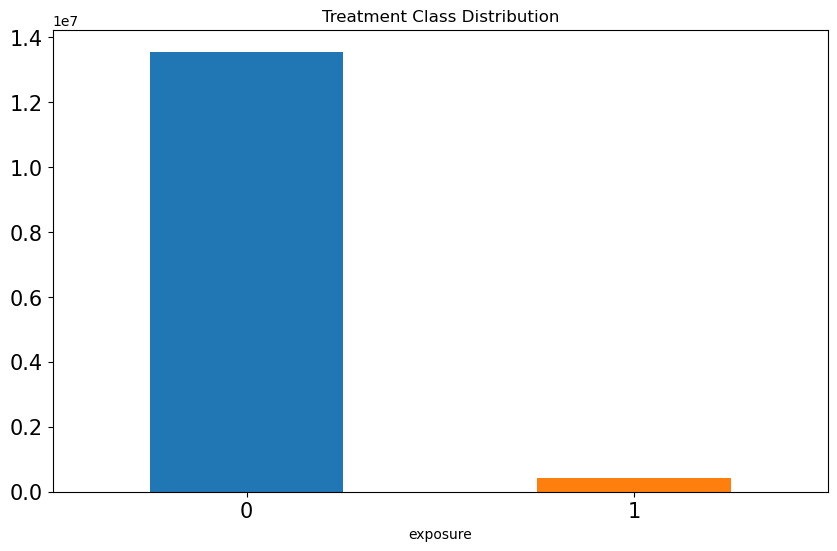

In [22]:
fig = plt.figure(figsize = (10,6))
target_count = df[treatment_col].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', int(round(target_count[1] / target_count[0])), ': 1')
target_count.plot(kind='bar', title='Treatment Class Distribution', color=['#2077B4', '#FF7F0E'], fontsize = 15)
plt.xticks(rotation=0) 

By seeing the distributions we can have an idea how skewed the target variable is - most of the users were in the treatment group. The problem is that many approaches uplift models assume the treatment group and the control group have a balanced distribution, which needs not hold in practice. In this case we may reweight, or resample, the training datasets such that the assumption becomes valid. According to Jaśkowski and Jaroszewicz (2012) resampling the treatment distribution can affect the learning algorithm and result in information loss, however, as long as the algorithm does a reasonably good job at modeling the conditional class distributions, the results will still be meaningful. As our dataset consists of 13M rows, we can be fairly confident any resampled dataset will contain enough instances to provide meaningful results.

Before proceeding with the random undersampling we have to separate the orginal dataframe so that the undersampling is only done on the training dataset. Why? for testing purposes, we want to test our models on a dataset with real life class distributions.

In [23]:
train, test  = train_test_split(df, test_size=0.2, random_state=42, stratify=df[treatment_col])

In [24]:
train = random_under(train, treatment_col)

In [25]:
train = target_class(train.drop(columns = drop_lst), treatment_col, target_col).reset_index(drop=True)
test = target_class(test.drop(columns = drop_lst), treatment_col, target_col).reset_index(drop=True)

In [26]:
X_train = train.drop([treatment_col,'target_class',target_col],axis=1)
y_train = train['target_class']
X_test = test.drop([treatment_col,'target_class', target_col],axis=1)
y_test = test['target_class']

Scaling features to have zero mean and unit variance

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Uplift Model Estimators Initialization and Prediction

### Solo Model (SM)
- **Estimator Initialization:** Initialized a logistic regression estimator for the SoloModel.
- **Fitting:** The SoloModel is fitted on the scaled training data using the `fit` method.
- **Prediction:** Uplift predictions are made on the scaled test data using the `predict` method.

### Two Models (TM)
- **Estimator Initialization:** Two logistic regression estimators are initialized, one for the treatment group and one for the control group, for the TwoModels.
- **Fitting:** The TwoModels is fitted on the scaled training data using the `fit` method.
- **Prediction:** Uplift predictions are made on the scaled test data using the `predict` method.

### Uplift LGWUM (Lift Generalized Weighted Uplift Modeling)
- **Model Fitting:** An XGBoost classifier is fitted on the scaled training data.
- **Prediction:** Uplift probabilities are predicted using the XGBoost classifier on the scaled test data.
- **Uplift Score Calculation:** The uplift score is calculated using the LGWUM formula based on the predicted uplift probabilities.

### LGWUM Formula:
The LGWUM formula for calculating uplift score is as follows:

𝑈𝑝𝑙𝑖𝑓𝑡 𝐿𝐺𝑊𝑈𝑀 = P(TR)/P(T) + P(CN)/P(C) - P(TN)/P(T) - P(CR)/P(C)

Where:
- \( P(CN) \) is the probability of an individual being a control non-responder,
- \( P(CR) \) is the probability of an individual being a control responder,
- \( P(TN) \) is the probability of an individual being a treatment non-responder, and
- \( P(TR) \) is the probability of an individual being a treatment responder.



In [28]:
# Initialize uplift model estimators
estimator_sm = LogisticRegression()
estimator_tm_treatment = LogisticRegression()
estimator_tm_control = LogisticRegression()

# Single Model (SoloModel)
sm = SoloModel(estimator_sm)
sm = sm.fit(X_train_scaled, train[target_col], train[treatment_col])
uplift_sm = sm.predict(X_test_scaled)

# Two Models (TwoModels)
tm = TwoModels(estimator_trmnt=estimator_tm_treatment, estimator_ctrl=estimator_tm_control, method='vanilla')
tm = tm.fit(X_train_scaled, train[target_col], train[treatment_col])
uplift_tm = tm.predict(X_test_scaled)

# Uplift LGWUM (Lift Generalized Weighted Uplift Modeling)
uplift_model = xgb.XGBClassifier().fit(X_train_scaled, train['target_class'])
uplift_proba = uplift_model.predict_proba(X_test_scaled)


uplift_lgwum = (uplift_proba[:, 0] / (uplift_proba[:, 0] + uplift_proba[:, 1])) + \
               (uplift_proba[:, 3] / (uplift_proba[:, 2] + uplift_proba[:, 3])) - \
               (uplift_proba[:, 2] / (uplift_proba[:, 2] + uplift_proba[:, 3])) - \
               (uplift_proba[:, 1] / (uplift_proba[:, 0] + uplift_proba[:, 1]))

Capturing the uplift scores from above three models

In [29]:
result_lgwum = compute_gain(X_test,uplift_lgwum, test[treatment_col],test[target_col]) 
result_sm = compute_gain(X_test,uplift_sm, test[treatment_col],test[target_col]) 
result_tm = compute_gain(X_test,uplift_tm, test[treatment_col],test[target_col]) 

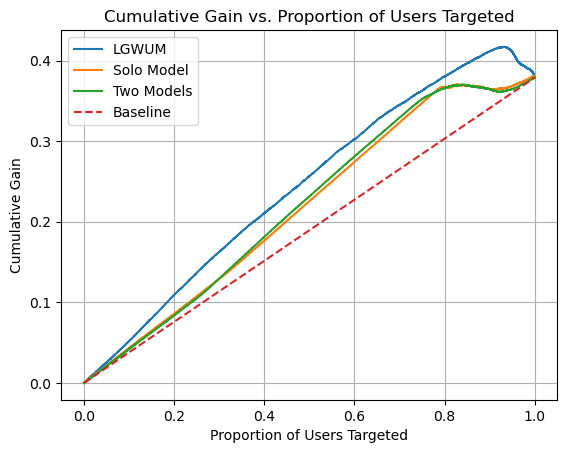

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Proportion of users targeted
proportion_users = np.arange(0, 1, (1/len(test)))

# Cumulative gain for each model
cumulative_gain_lgwum = result_lgwum['cum_gain2']
cumulative_gain_sm = result_sm['cum_gain2']
cumulative_gain_tm = result_tm['cum_gain2']

# Baseline (random targeting)
baseline = np.linspace(0, cumulative_gain_tm.max(), len(test))

# Plotting
plt.plot(proportion_users, cumulative_gain_lgwum, label='LGWUM')
plt.plot(proportion_users, cumulative_gain_sm, label='Solo Model')
plt.plot(proportion_users, cumulative_gain_tm, label='Two Models')
plt.plot(proportion_users, baseline, label='Baseline', linestyle='--')

plt.xlabel('Proportion of Users Targeted')
plt.ylabel('Cumulative Gain')
plt.title('Cumulative Gain vs. Proportion of Users Targeted')
plt.legend()
plt.grid(True)
plt.show()

### The graph above shows the following:

- The x axis is the proportion of data used by the company to send the targeted marketing.
- The y axis is the uplift obtained for targeting the users.
- The curves show the cummulative profit of users that were sorted by their probability of being converted. In other words, the first users targeted are the ones with highest uplift.


#### Regarding the models:

- All models get eventually to the 35% of uplift after targeting all the users.
- The objective of the curves is to show that if only 50% of the users are targeted, then it would be wise to use the results of the LGWUM model because it reaches almost 27% of the uplift, while the random selection would only reach around half of the maximum uplift. The proportion of users can be changed based on the needs of the company.
- The results of the single and two models have similar behaviour, but the LGWUM model still provide better results from 0.2 to 0.9 proportion of users.

#### As well the graph implies the following:

- The first part of the curve are the users are the persudables, followed by the sure things and lost causes, and finally the sleeping dogs.
- The ideal curve is the one that with the first amount of instances reaches the maximum uplift, then the curve keeps the same level of uplift due to the sure things and lost causes, and finally the curve will decrease at some point due to the sleeping dogs.